# Align2D — Simple Demo
Align two HAADF-STEM images of a perovskite crystal acquired at 0° and 90° specimen rotation.

In [1]:
# Install in Google Colab
try:
    import google.colab
    !pip install -q -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ quantem-widget
except ImportError:
    pass  # Not in Colab, skip

In [2]:
try:
    %load_ext autoreload
    %autoreload 2
    %env ANYWIDGET_HMR=1
except Exception:
    pass  # autoreload unavailable (Colab Python 3.12+)

env: ANYWIDGET_HMR=1


In [3]:
import numpy as np
import torch
from scipy.ndimage import shift as ndi_shift
import quantem.widget
from quantem.widget import Align2D, Show2D
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
rng = np.random.default_rng(42)
N = 512
# Perovskite crystal (SrTiO3-like [001] HAADF-STEM simulation)
rows = torch.arange(N, device=device, dtype=torch.float32)
yy, xx = torch.meshgrid(rows, rows, indexing="ij")
img = torch.zeros((N, N), device=device, dtype=torch.float32)
a = 16       # lattice parameter (px)
sig_a = 2.2  # A-site column width (Sr, heavy)
sig_b = 1.8  # B-site column width (Ti, lighter)
# A-site columns (bright) at lattice corners
ni = N // a + 3
ai_idx = torch.arange(-1, ni, device=device, dtype=torch.float32)
a_cx = (ai_idx * a).unsqueeze(1)  # (ni, 1)
a_cy = (ai_idx * a).unsqueeze(0)  # (1, ni)
a_cx_flat = a_cx.expand(ni + 1, ni + 1).reshape(-1, 1, 1)  # (P, 1, 1)
a_cy_flat = a_cy.expand(ni + 1, ni + 1).reshape(-1, 1, 1)
img += (torch.exp(-((xx.unsqueeze(0) - a_cx_flat)**2 + (yy.unsqueeze(0) - a_cy_flat)**2) / (2 * sig_a**2))).sum(0)
# B-site columns (dimmer) at body center
b_cx = (ai_idx * a + a / 2).unsqueeze(1)
b_cy = (ai_idx * a + a / 2).unsqueeze(0)
b_cx_flat = b_cx.expand(ni + 1, ni + 1).reshape(-1, 1, 1)
b_cy_flat = b_cy.expand(ni + 1, ni + 1).reshape(-1, 1, 1)
img += 0.55 * (torch.exp(-((xx.unsqueeze(0) - b_cx_flat)**2 + (yy.unsqueeze(0) - b_cy_flat)**2) / (2 * sig_b**2))).sum(0)
# Defects: A-site vacancies (missing bright columns)
vac_pos = torch.tensor([(4, 7), (9, 14), (14, 5), (7, 21), (19, 17)], device=device, dtype=torch.float32)
vac_x = (vac_pos[:, 0] * a).reshape(-1, 1, 1)
vac_y = (vac_pos[:, 1] * a).reshape(-1, 1, 1)
img -= 0.9 * (torch.exp(-((xx.unsqueeze(0) - vac_x)**2 + (yy.unsqueeze(0) - vac_y)**2) / (2 * (sig_a + 0.3)**2))).sum(0)
# Defects: anti-site (heavy atom on B-site, anomalously bright)
anti_pos = torch.tensor([(6, 11), (16, 8)], device=device, dtype=torch.float32)
anti_cx = (anti_pos[:, 0] * a + a / 2).reshape(-1, 1, 1)
anti_cy = (anti_pos[:, 1] * a + a / 2).reshape(-1, 1, 1)
img += 0.35 * (torch.exp(-((xx.unsqueeze(0) - anti_cx)**2 + (yy.unsqueeze(0) - anti_cy)**2) / (2 * sig_a**2))).sum(0)
# Edge dislocation strain field
disl_x, disl_y = N * 0.65, N * 0.4
theta = torch.atan2(yy - disl_y, xx - disl_x)
r_d = torch.sqrt((xx - disl_x)**2 + (yy - disl_y)**2) + 1
img += 0.12 * torch.sin(theta) / torch.sqrt(r_d / 20)
# Specimen envelope
r = torch.sqrt((xx - N / 2)**2 + (yy - N / 2)**2)
img *= torch.exp(-torch.clamp(r - N * 0.38, min=0)**2 / (2 * 35**2))
# Convert to numpy, add scan noise
img = img.cpu().numpy()
img += rng.normal(0, 0.04, (N, N)).astype(np.float32)
img = img.astype(np.float32)
# 0° / 90° rotation pair
rotation_deg = 90
img_0 = img.copy()
img_90 = np.rot90(img, k=1).copy()  # 90° CCW rotation
img_90 = ndi_shift(img_90, (5.3, -3.8), order=3, mode='reflect').astype(np.float32)
img_90 += rng.normal(0, 0.04, (N, N)).astype(np.float32)
print(f"Image 0°:  {img_0.shape}")
print(f"Image 90°: {img_90.shape}")
print(f"Rotation: {rotation_deg}°")
print(f"Device: {device}")
print(f"quantem.widget {quantem.widget.__version__}")

Image 0°:  (512, 512)
Image 90°: (512, 512)
Rotation: 90°
Device: mps
quantem.widget 0.4.0a3


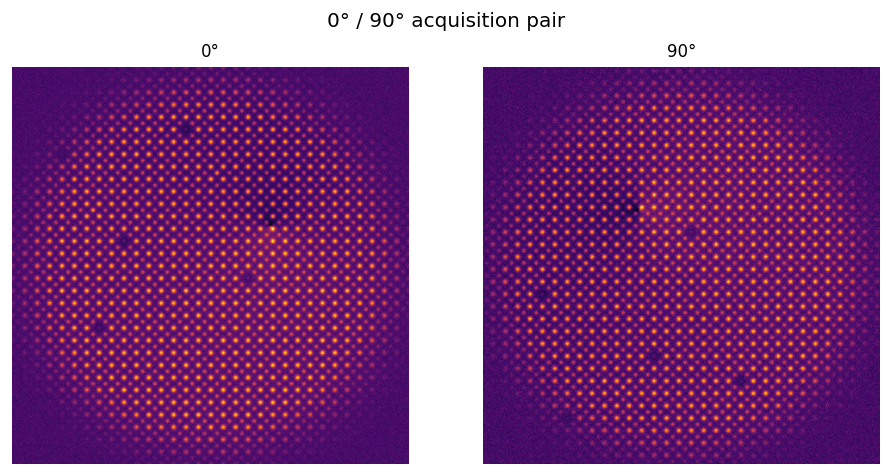

In [4]:
Show2D([img_0, img_90], title="0° / 90° acquisition pair", labels=["0°", "90°"])

## Align2D — rotation correction + translation alignment
Correct the known 90° rotation, then use phase correlation to find the residual sub-pixel translation.

In [5]:
# Correct the known 90° rotation, then align residual translation
img_90_corrected = np.rot90(img_90, k=-1)
w = Align2D(
    img_0, img_90_corrected,
    title="Crystal alignment (rotation-corrected)",
    label_a="0° (ref)", label_b="90° (corrected)",
)
w

Align2D(512×512, dx=5.2, dy=3.9, rot=0.0°)

In [6]:
dx, dy = w.offset
print(f"Rotation: {rotation_deg}°")
print(f"Translation: dx={dx:.2f}, dy={dy:.2f}")
print(f"NCC: {w.xcorr_zero:.3f} (before) → {w.ncc_aligned:.3f} (after)")

Rotation: 90°
Translation: dx=5.21, dy=3.88
NCC: 0.006 (before) → 0.755 (after)


## Inspect Widget State

In [7]:
w.summary()

Crystal alignment (rotation-corrected)
════════════════════════════════
Image:    512×512
Labels:   A='0° (ref)'  B='90° (corrected)'
Offset:   dx=5.21  dy=3.88  rotation=0.00°
Display:  gray | opacity=50% | padding=20%
NCC:      aligned=0.7547  zero=0.0059
